In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from os import path

In [2]:
def parse_batch(file_name):
    parsed = pd.read_csv(file_name, sep=' ', header=None).rename(columns={0:'pep_seq', 1:'charge', 2:'spectra'})
    #parsed['spectra'] = parsed['spectra'].str.split('/').str[-1]
    return parsed

In [3]:
def parse_raw(batch_row):
    protein, _, mz, rt = batch_row['spectra'].split('/')[-1].split('_')
    rt = rt.split('.txt')[0]
    fit_file = batch_row['spectra'].split('.txt')[0]+'.fit'
    dat_file = batch_row['spectra'].split('.txt')[0]+'.dat'
    assert path.exists(fit_file)
    assert path.exists(dat_file)
    return {'protein_name':protein, 'mz':float(mz), 'retention_time':float(rt), 
            'raw_data':batch_row['spectra'], 'fit_data':fit_file, 'dat_file':dat_file, 
            'charge':batch_row['charge'], 'pep_seq':batch_row['pep_seq']}

In [4]:
def read_spectra(spectra_dict):
    raw_read = pd.read_csv(spectra_dict['raw_data'], sep=' ', header=None).rename(columns={0:'m/z', 1:'intensity'})
    dat_read = pd.read_csv(spectra_dict['dat_file'], sep=',', header=None).rename(columns={0:'mass', 1:'fit_intensity', 2:'resid_intensity'})
    fit_read = pd.read_csv(spectra_dict['fit_data'], sep=',', header=None).rename(columns={0:'mass', 1:'intensity'})
    fit_read['m/z'] = fit_read['mass']/spectra_dict['charge']
    raw_read['fit_int'] = np.interp(raw_read['m/z'], fit_read['m/z'], fit_read['intensity'])
    raw_read['resid'] = raw_read['intensity'] - raw_read['fit_int']
    plottable_name = spectra_dict['protein_name']+' | ' + str(spectra_dict['retention_time']) + ' mins'
    return {'plottable': raw_read, 'fit': fit_read, 'dat': dat_read, 'name': plottable_name}

In [5]:
def plot_isodist(plottable_dict, fig_dims = (10, 5)):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=fig_dims, gridspec_kw={'height_ratios': [5, 1]})
    sns.lineplot(data=plottable_dict['plottable'], x='m/z', y='fit_int', ax=axes[0], color='orange').set_title(plottable_dict['name'])
    sns.scatterplot(data=plottable_dict['plottable'], x='m/z', y='intensity', marker='x', ax=axes[0], color='black')
    sns.lineplot(data=plottable_dict['plottable'], x='m/z', y='resid', ax=axes[1], color='red')
    plt.tight_layout()

In [6]:
def parse_and_plot(batch_row):
    spectra_dict = parse_raw(batch_row)
    plottable_dict = read_spectra(spectra_dict)
    plot_isodist(plottable_dict)

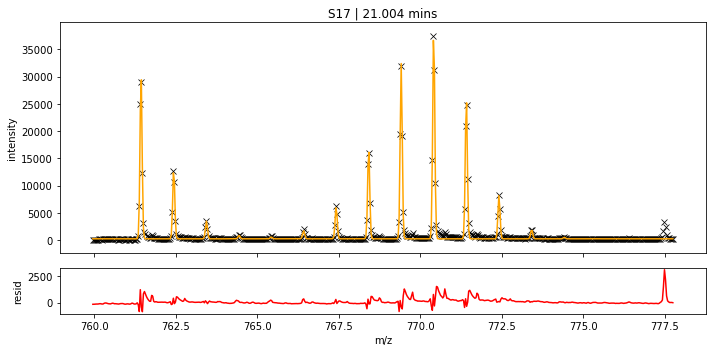

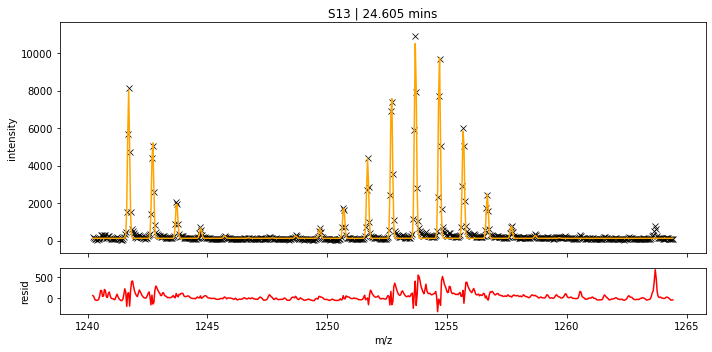

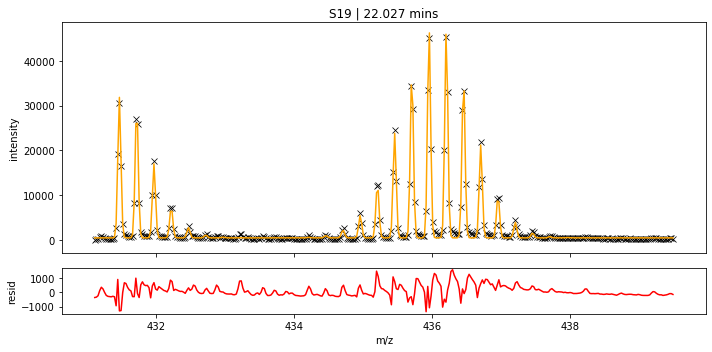

In [7]:
all_spectra = parse_batch('./14N_partial_TOF.batch')
for index in all_spectra.index:
    parse_and_plot(all_spectra.iloc[index])